# 1. Mesoscopic Coarse-Graining

Calculating Gaussian field...


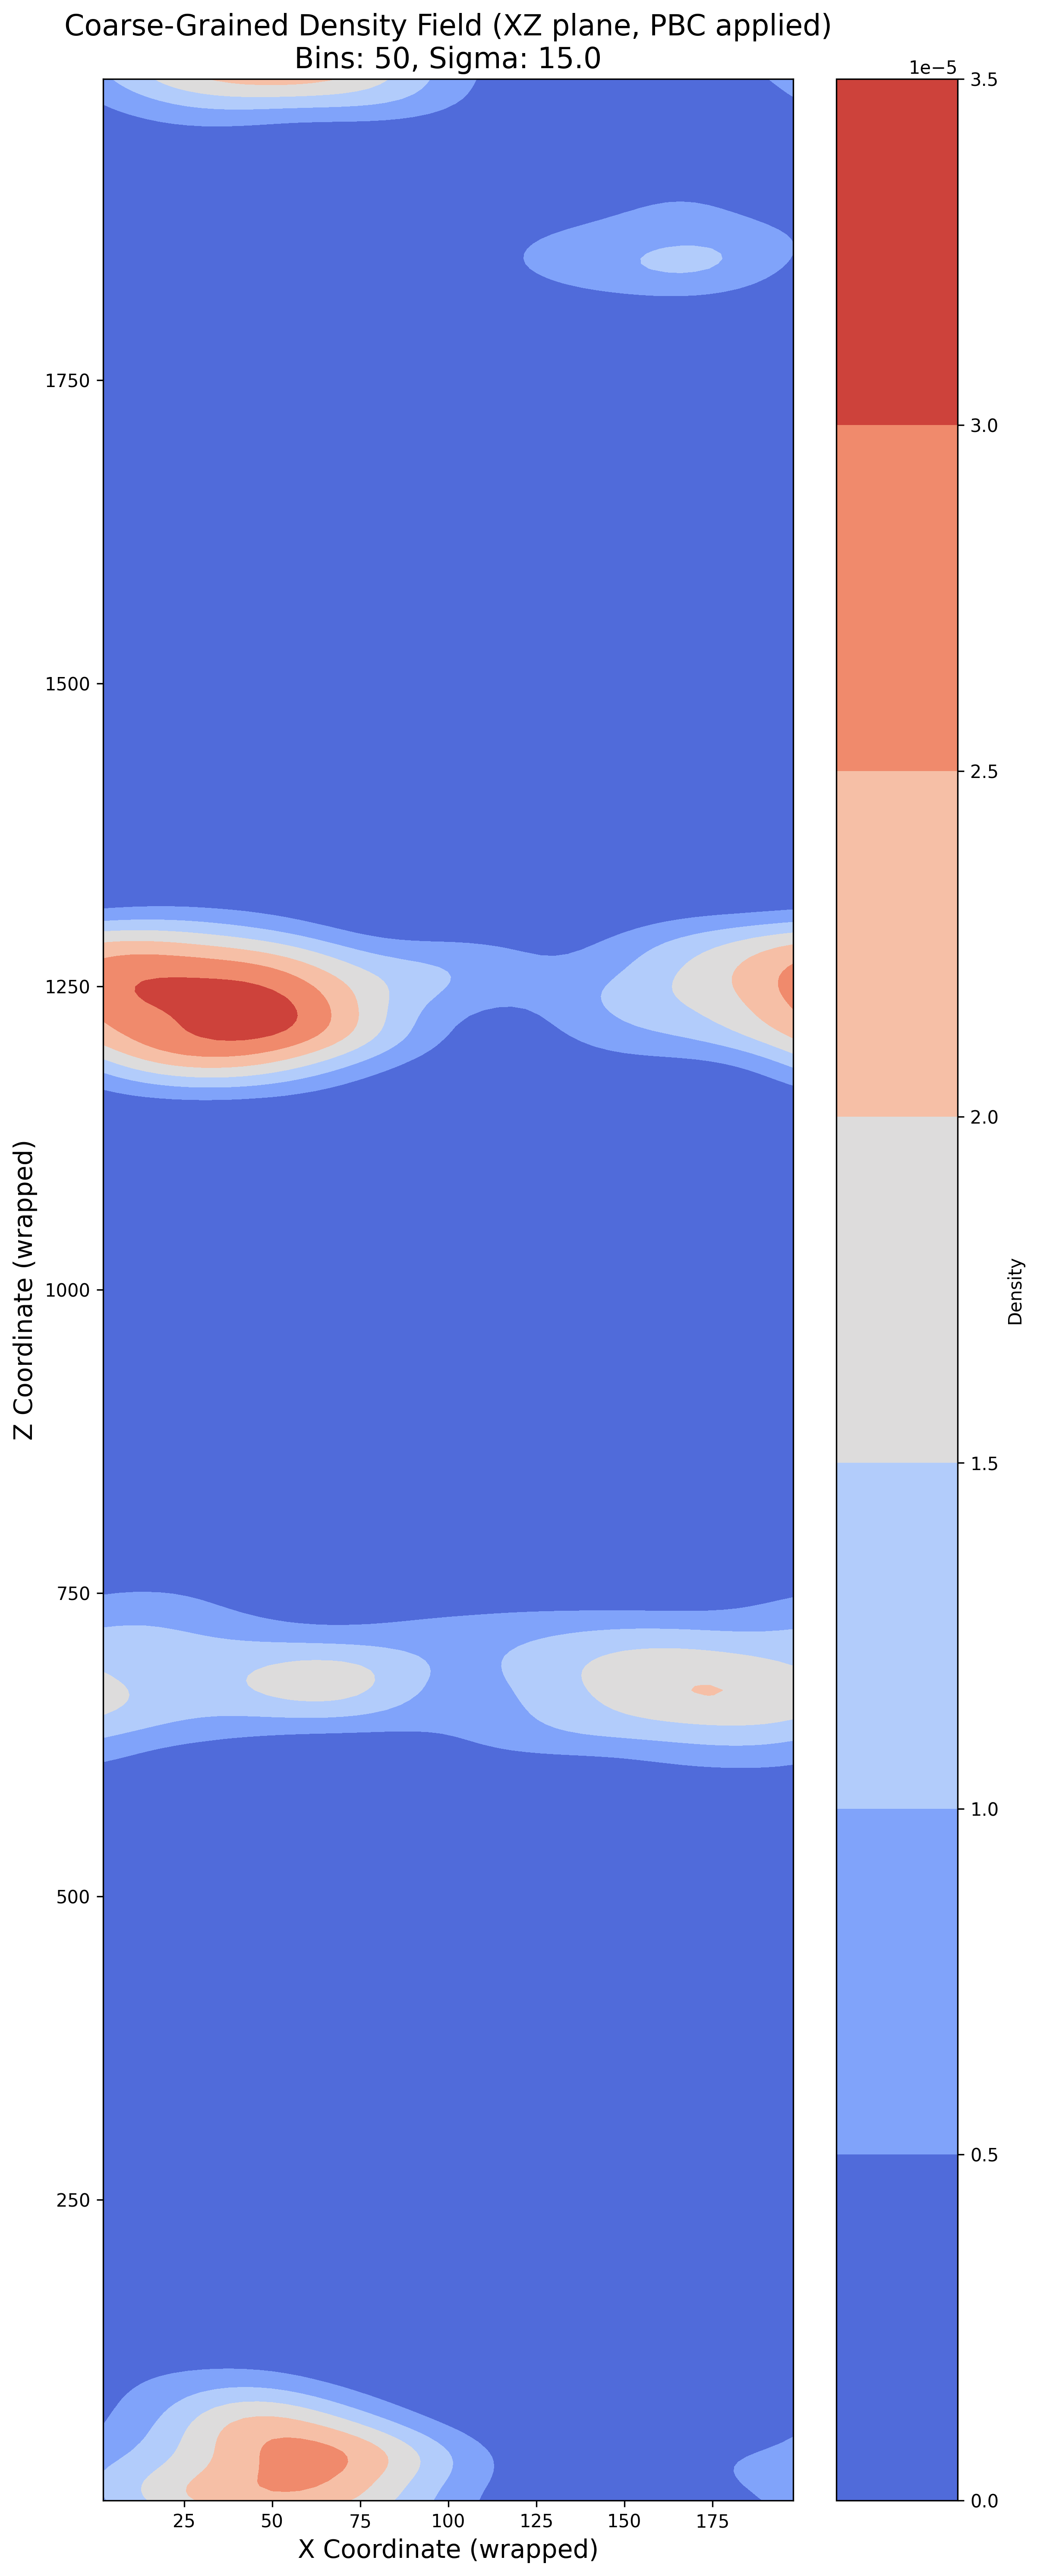

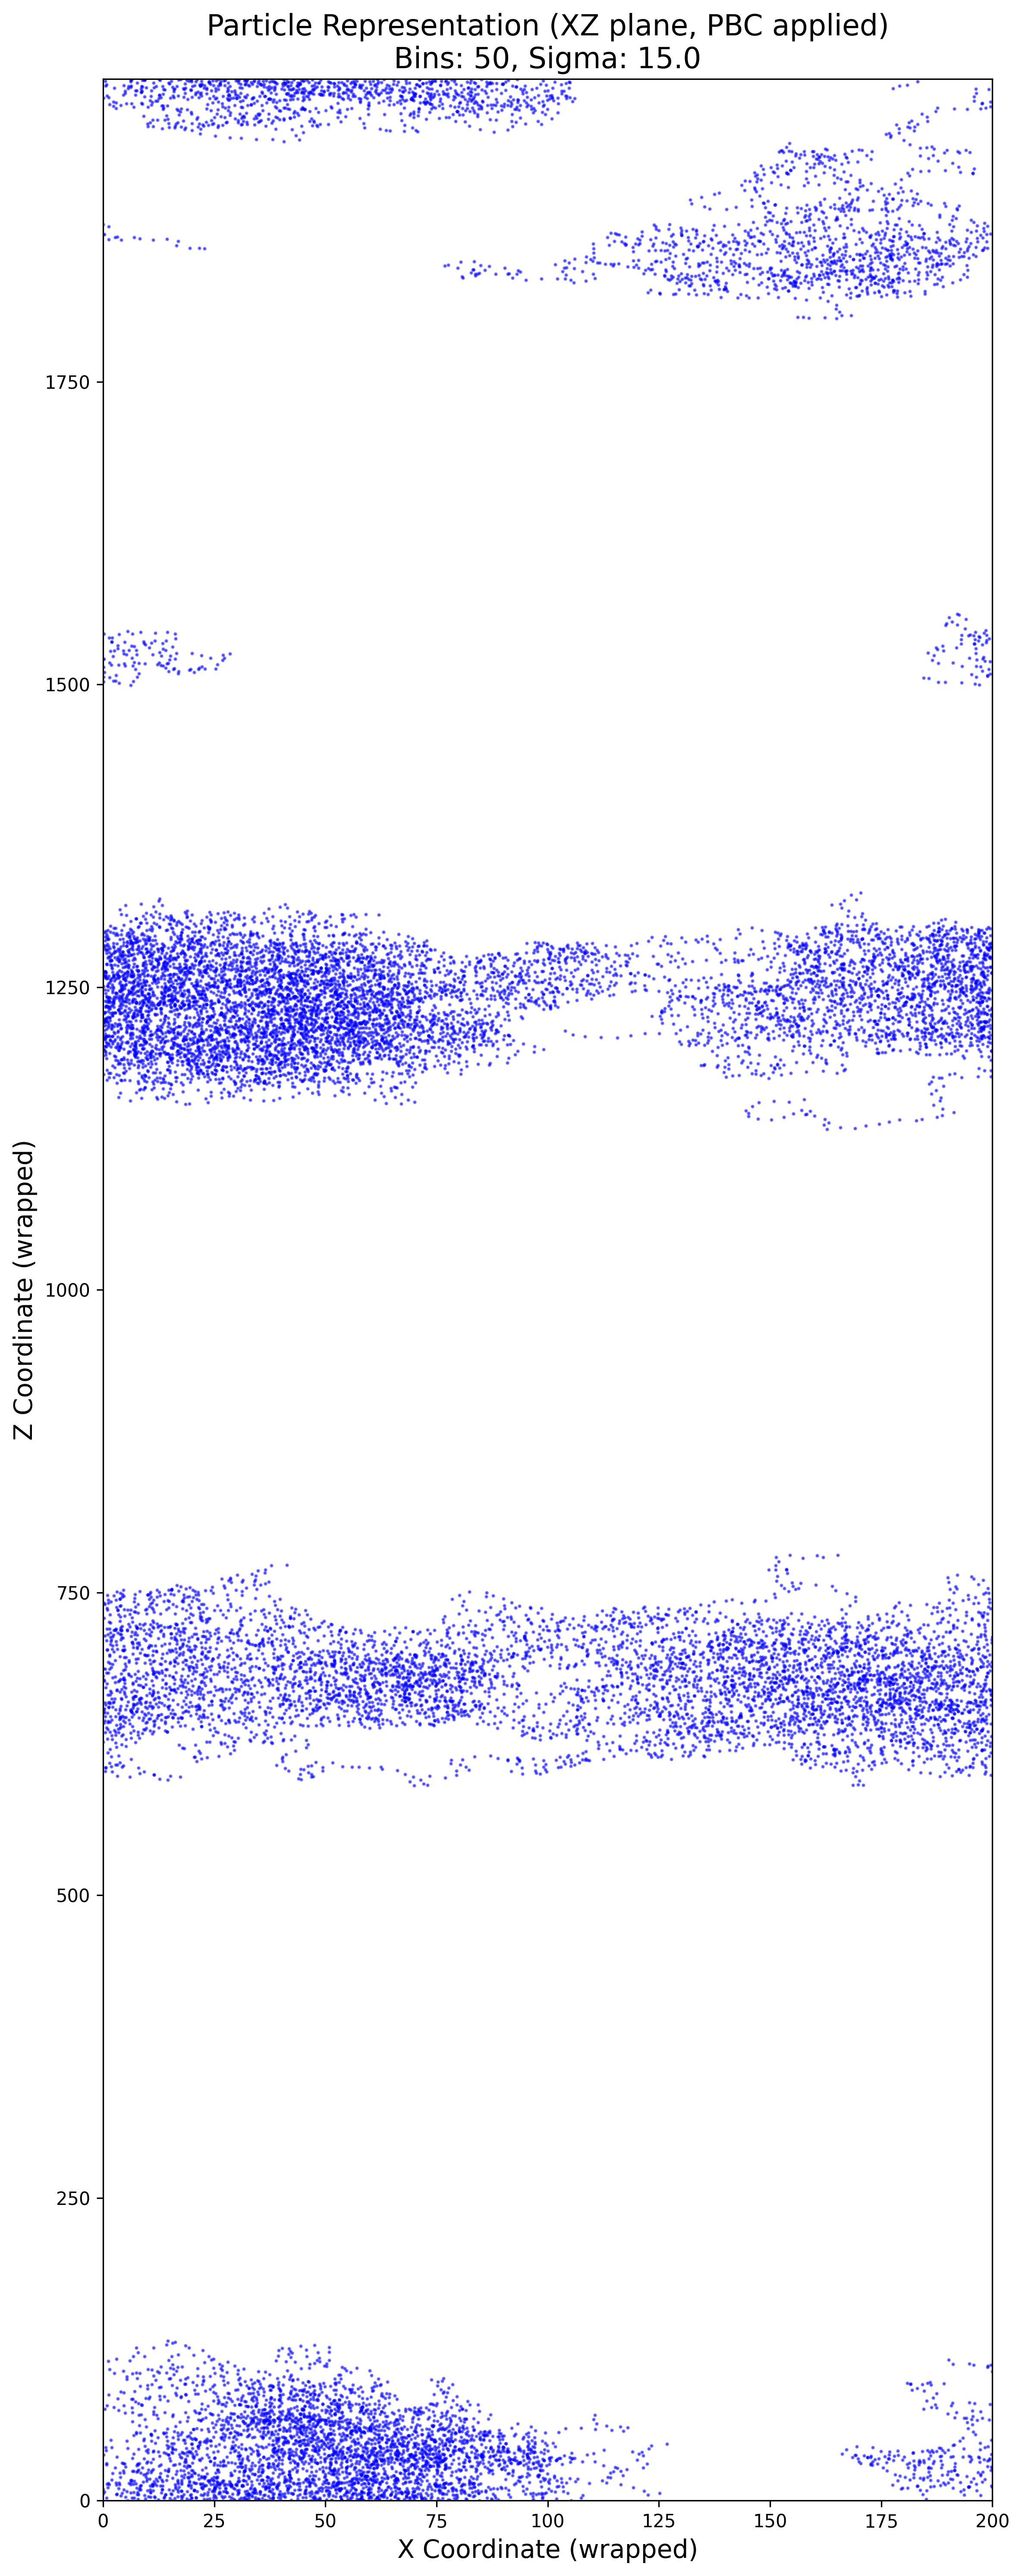

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants
N_particle = 19560  # Number of particles
header_lines_per_frame = 9  # Number of lines in the header (TIMESTEP, NUMBER OF ATOMS, BOX BOUNDS, etc.)
lines_per_frame = N_particle + header_lines_per_frame  # Total number of lines per frame
linear_bins = 50  # Number of bins for coarse-graining along the x-axis
sigma_md = 15.00  # Gaussian coarse-graining parameter
z_to_x_ratio = 10  # Define the ratio of z to x delta

Gaussian_Energy = lambda x, z: 1 / (2 * np.pi * sigma_md**2) * np.exp(-0.5 * (x**2 + z**2) / sigma_md**2)

# File paths
file_name = '933.lammpstrj'  # Use the 933th snapshot of the CG MD simulation (full lammpstrj file is available in Zenodo)
data_path = './'  # Update with the correct path
file_path = os.path.join(data_path, file_name)

# Function to apply periodic boundary conditions (PBC)
def apply_pbc(coordinate, box_min, box_max):
    """Apply PBC to map coordinates back into the simulation box"""
    box_length = box_max - box_min
    return box_min + (coordinate - box_min) % box_length

# Function to jump to the specific frame in LAMMPS trajectory and parse it
def read_specific_snapshot_fast(file_path, snapshot_idx, N_particle):
    """Jump directly to the specific snapshot in the LAMMPS trajectory file and read atom coordinates"""
    with open(file_path, 'r') as file:
        # Jump to the start of the desired frame
        start_line = snapshot_idx * lines_per_frame
        file.seek(0)  # Go to the beginning of the file
        
        # Skip directly to the start of the frame
        for _ in range(start_line):
            file.readline()

        # Read the header information for the frame (box bounds)
        while True:
            line = file.readline().strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                box_x_min, box_x_max = map(float, file.readline().split())
                file.readline()  # Skip the y box bounds line (not used)
                box_z_min, box_z_max = map(float, file.readline().split())
                break

        # Read the atom coordinates
        X_cor, Z_cor = [], []
        while True:
            line = file.readline().strip()
            if line.startswith("ITEM: ATOMS"):
                break

        for _ in range(N_particle):
            atom_data = file.readline().split()
            if len(atom_data) >= 5:  # Ensure there's enough data
                xu = float(atom_data[2])  # unwrapped x coordinate
                zu = float(atom_data[4])  # unwrapped z coordinate

                # Apply PBC using the box dimensions
                X_cor.append(apply_pbc(xu, box_x_min, box_x_max))
                Z_cor.append(apply_pbc(zu, box_z_min, box_z_max))

    return np.array(X_cor), np.array(Z_cor), box_x_max - box_x_min, box_z_max - box_z_min

# Gaussian coarse-graining over the xz plane with field values
def coarse_grain_gaussian(X_cor, Z_cor, box_len_x, box_len_z, bins, sigma_md, z_to_x_ratio=10):
    # Adjust z_bins to make sure delta_z = z_to_x_ratio * delta_x
    x_edges = np.linspace(0, box_len_x, bins + 1)
    z_edges = np.linspace(0, box_len_z, bins * z_to_x_ratio + 1)  # z has more bins

    x_coordinate = (x_edges[0:-1] + x_edges[1:]) * 0.5
    z_coordinate = (z_edges[0:-1] + z_edges[1:]) * 0.5

    x_mesh, z_mesh = np.meshgrid(x_coordinate, z_coordinate)  # Create consistent mesh

    # Generate field for coarse-graining
    field = np.zeros((len(z_coordinate), len(x_coordinate)))

    # Perform Gaussian coarse-graining for each particle
    print("Calculating Gaussian field...")
    for i in range(N_particle):
        x_value = X_cor[i]
        z_value = Z_cor[i]

        # Calculate the difference between the particle position and the grid points
        ddx = (x_mesh - x_value)
        ddx = ddx * (abs(ddx) < box_len_x / 2) - np.sign(ddx) * (box_len_x - abs(ddx)) * (abs(ddx) >= box_len_x / 2)
        
        ddz = (z_mesh - z_value)
        ddz = ddz * (abs(ddz) < box_len_z / 2) - np.sign(ddz) * (box_len_z - abs(ddz)) * (abs(ddz) >= box_len_z / 2)
        
        # Add the Gaussian function centered at the particle position
        field += Gaussian_Energy(ddx, ddz)
    
    # Normalize the field by the number of particles
    field /= N_particle
    
    return field, x_coordinate, z_coordinate

# Plotting coarse-grained density field with the correct aspect ratio and larger figure
def plot_density_field(field, x_coordinate, z_coordinate, box_len_x, box_len_z, linear_bins, sigma_md):
    plt.figure(figsize=(8, 20), dpi=300)  # Larger figure size and higher DPI for clarity
    plt.contourf(x_coordinate, z_coordinate, field, cmap='coolwarm')
    plt.colorbar(label='Density')
    plt.xlabel('X Coordinate (wrapped)', fontsize=14)
    plt.ylabel('Z Coordinate (wrapped)', fontsize=14)
    plt.title(f'Coarse-Grained Density Field (XZ plane, PBC applied)\nBins: {linear_bins}, Sigma: {sigma_md}', fontsize=16)
    
    # Set the aspect ratio based on the box dimensions    
    #plt.gca().set_aspect(box_len_z / box_len_x)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f'coarse_grained_density_field_bins{linear_bins}_sigma{sigma_md}.pdf', bbox_inches='tight')  # Save the figure as PDF
    plt.show()

# Plotting particle positions with correct aspect ratio and larger figure
def plot_particle_positions(X_cor, Z_cor, box_len_x, box_len_z, linear_bins, sigma_md):
    plt.figure(figsize=(8, 20), dpi=300)  # Larger figure size and higher DPI for clarity
    plt.scatter(X_cor, Z_cor, s=1, c='blue', alpha=0.5)  # Scatter plot of particles
    plt.xlabel('X Coordinate (wrapped)', fontsize=14)
    plt.ylabel('Z Coordinate (wrapped)', fontsize=14)
    plt.title(f'Particle Representation (XZ plane, PBC applied)\nBins: {linear_bins}, Sigma: {sigma_md}', fontsize=16)
    
    # Set the aspect ratio based on the box dimensions    
    #plt.gca().set_aspect(box_len_z / box_len_x)
    
    plt.xlim(0, box_len_x)
    plt.ylim(0, box_len_z)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f'particle_representation_bins{linear_bins}_sigma{sigma_md}.pdf', bbox_inches='tight')  # Save the figure as PDF
    plt.show()

# Main processing for a specific snapshot
snapshot_idx = 0 # Set 933 for the full lammpstrj file as it reflects example snapshot index (for the 933rd snapshot)

# Read the specific snapshot and box size using unwrapped coordinates and apply PBC
X_cor, Z_cor, box_len_x, box_len_z = read_specific_snapshot_fast(file_path, snapshot_idx, N_particle)

# Perform Gaussian coarse-graining and plot
field, x_coordinate, z_coordinate = coarse_grain_gaussian(X_cor, Z_cor, box_len_x, box_len_z, linear_bins, sigma_md, z_to_x_ratio)
plot_density_field(field, x_coordinate, z_coordinate, box_len_x, box_len_z, linear_bins, sigma_md)

# Plot particle positions
plot_particle_positions(X_cor, Z_cor, box_len_x, box_len_z, linear_bins, sigma_md)


# 2. Grid Setting (Optional)

Calculating Gaussian field...


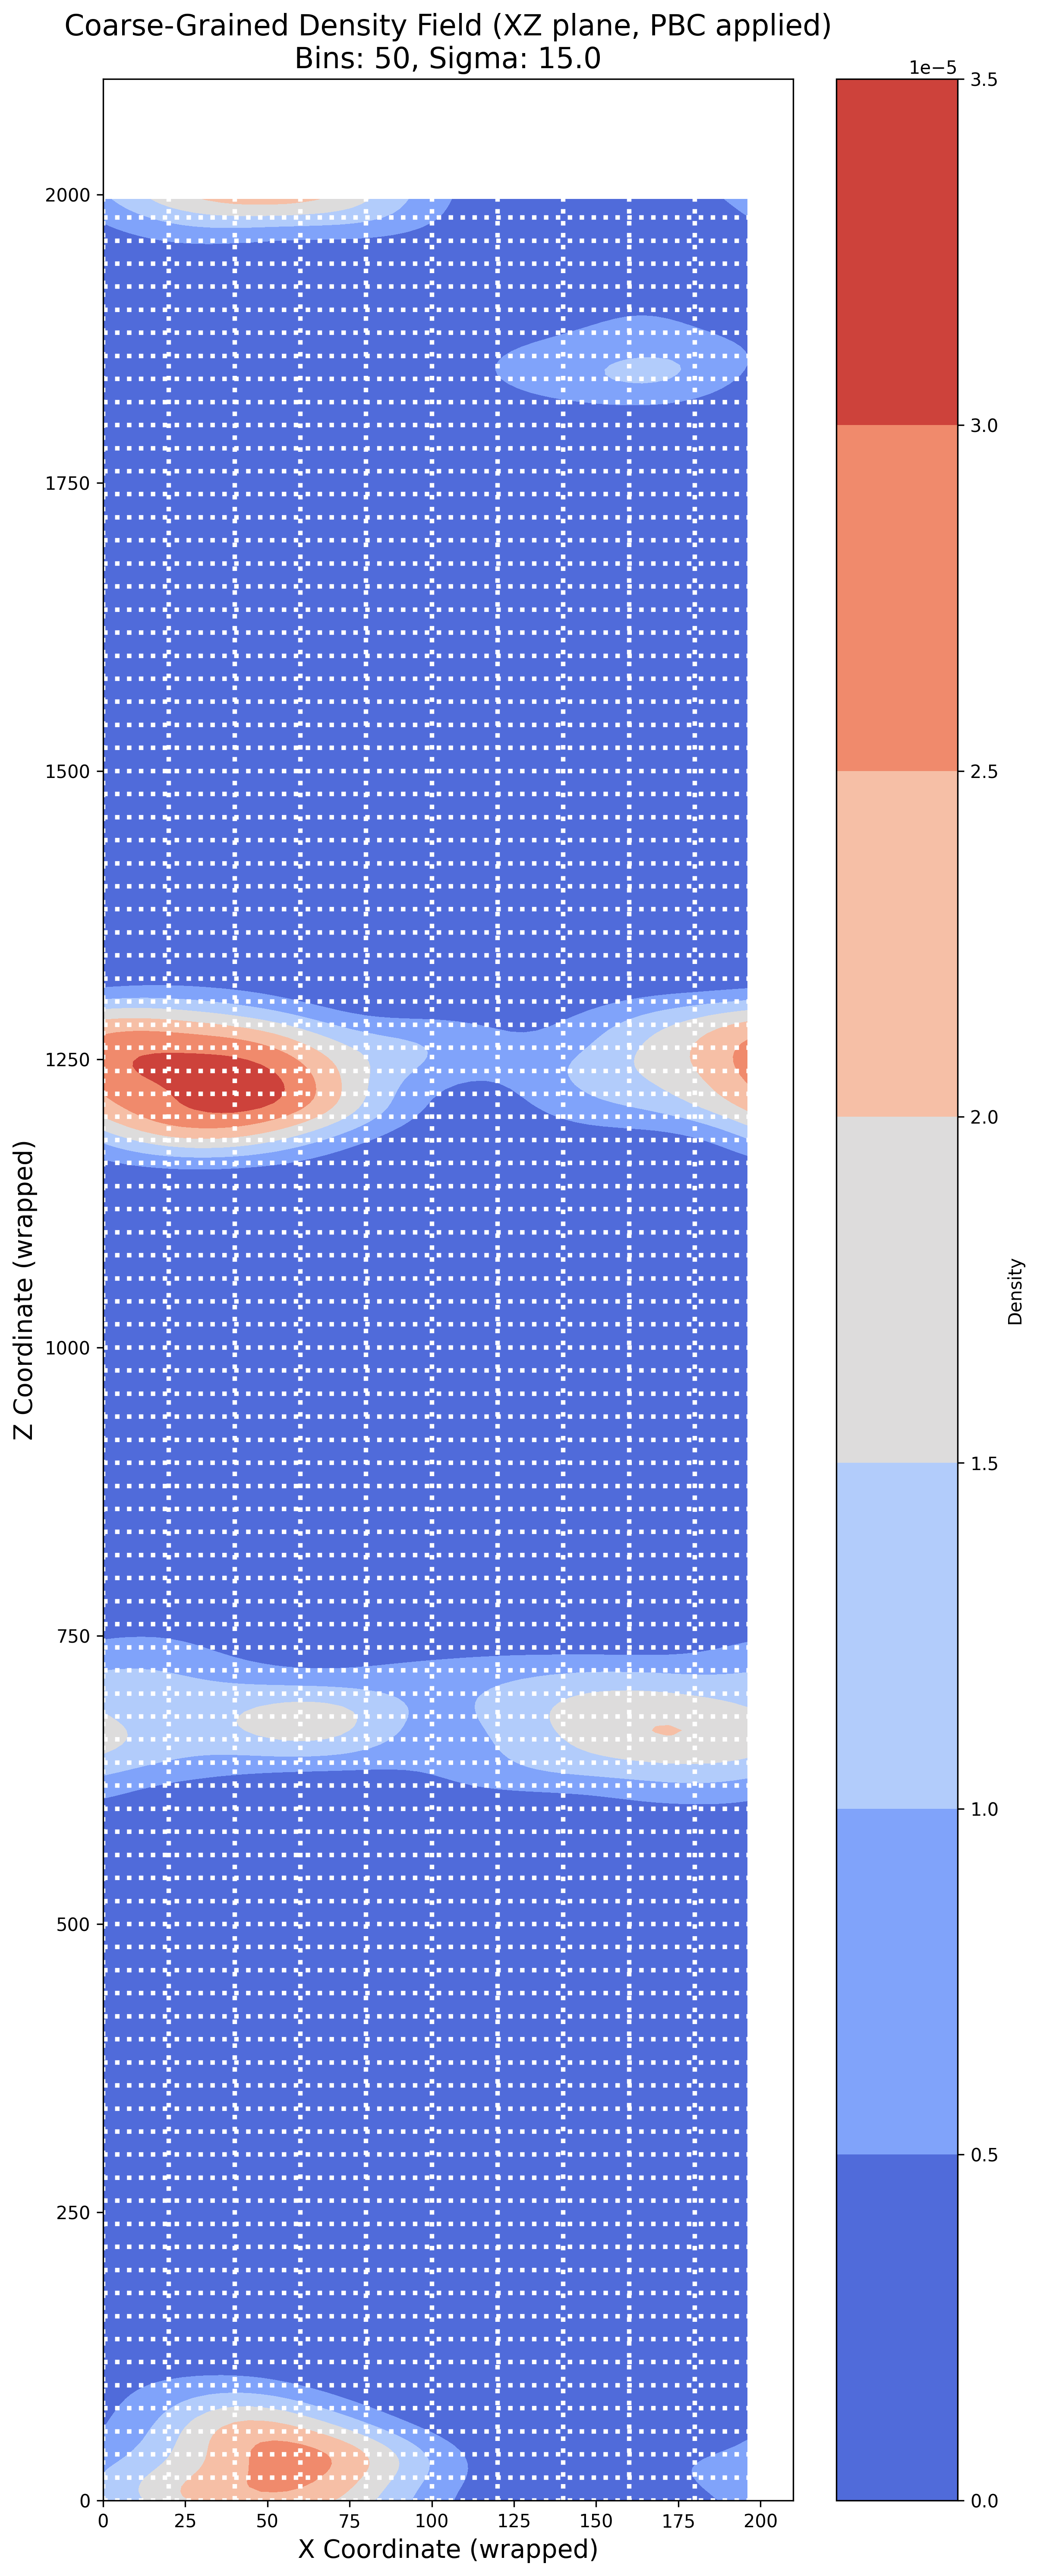

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants
N_particle = 19560  # Number of particles
header_lines_per_frame = 9  # Number of lines in the header (TIMESTEP, NUMBER OF ATOMS, BOX BOUNDS, etc.)
lines_per_frame = N_particle + header_lines_per_frame  # Total number of lines per frame
linear_bins = 50  # Number of bins for coarse-graining along the x-axis
sigma_md = 15.00  # Gaussian coarse-graining parameter
z_to_x_ratio = 10  # Define the ratio of z to x delta

Gaussian_Energy = lambda x, z: 1 / (2 * np.pi * sigma_md**2) * np.exp(-0.5 * (x**2 + z**2) / sigma_md**2)

# File paths
file_name = '933.lammpstrj'  # Use the 933th snapshot of the CG MD simulation (full lammpstrj file is available in Zenodo)
data_path = './'  # Update with the correct path
file_path = os.path.join(data_path, file_name)

# Function to apply periodic boundary conditions (PBC)
def apply_pbc(coordinate, box_min, box_max):
    """Apply PBC to map coordinates back into the simulation box"""
    box_length = box_max - box_min
    return box_min + (coordinate - box_min) % box_length

# Function to jump to the specific frame in LAMMPS trajectory and parse it
def read_specific_snapshot_fast(file_path, snapshot_idx, N_particle):
    """Jump directly to the specific snapshot in the LAMMPS trajectory file and read atom coordinates"""
    with open(file_path, 'r') as file:
        # Jump to the start of the desired frame
        start_line = snapshot_idx * lines_per_frame
        file.seek(0)  # Go to the beginning of the file
        
        # Skip directly to the start of the frame
        for _ in range(start_line):
            file.readline()

        # Read the header information for the frame (box bounds)
        while True:
            line = file.readline().strip()
            if line.startswith("ITEM: BOX BOUNDS"):
                box_x_min, box_x_max = map(float, file.readline().split())
                file.readline()  # Skip the y box bounds line (not used)
                box_z_min, box_z_max = map(float, file.readline().split())
                break

        # Read the atom coordinates
        X_cor, Z_cor = [], []
        while True:
            line = file.readline().strip()
            if line.startswith("ITEM: ATOMS"):
                break

        for _ in range(N_particle):
            atom_data = file.readline().split()
            if len(atom_data) >= 5:  # Ensure there's enough data
                xu = float(atom_data[2])  # unwrapped x coordinate
                zu = float(atom_data[4])  # unwrapped z coordinate

                # Apply PBC using the box dimensions
                X_cor.append(apply_pbc(xu, box_x_min, box_x_max))
                Z_cor.append(apply_pbc(zu, box_z_min, box_z_max))

    return np.array(X_cor), np.array(Z_cor), box_x_max - box_x_min, box_z_max - box_z_min

# Gaussian coarse-graining over the xz plane with field values
def coarse_grain_gaussian(X_cor, Z_cor, box_len_x, box_len_z, bins, sigma_md, z_to_x_ratio=10):
    # Adjust z_bins to make sure delta_z = z_to_x_ratio * delta_x
    x_edges = np.linspace(0, box_len_x, bins + 1)
    z_edges = np.linspace(0, box_len_z, bins * z_to_x_ratio + 1)  # z has more bins

    x_coordinate = (x_edges[0:-1] + x_edges[1:]) * 0.5
    z_coordinate = (z_edges[0:-1] + z_edges[1:]) * 0.5

    x_mesh, z_mesh = np.meshgrid(x_coordinate, z_coordinate)  # Create consistent mesh

    # Generate field for coarse-graining
    field = np.zeros((len(z_coordinate), len(x_coordinate)))

    # Perform Gaussian coarse-graining for each particle
    print("Calculating Gaussian field...")
    for i in range(N_particle):
        x_value = X_cor[i]
        z_value = Z_cor[i]

        # Calculate the difference between the particle position and the grid points
        ddx = (x_mesh - x_value)
        ddx = ddx * (abs(ddx) < box_len_x / 2) - np.sign(ddx) * (box_len_x - abs(ddx)) * (abs(ddx) >= box_len_x / 2)
        
        ddz = (z_mesh - z_value)
        ddz = ddz * (abs(ddz) < box_len_z / 2) - np.sign(ddz) * (box_len_z - abs(ddz)) * (abs(ddz) >= box_len_z / 2)
        
        # Add the Gaussian function centered at the particle position
        field += Gaussian_Energy(ddx, ddz)
    
    # Normalize the field by the number of particles
    field /= N_particle
    
    return field, x_edges, z_edges

# Plotting coarse-grained density field with reduced grid lines
def plot_density_field_with_grid(field, x_edges, z_edges, box_len_x, box_len_z, linear_bins, sigma_md):
    plt.figure(figsize=(8, 20), dpi=300)  # Larger figure size and higher DPI for clarity
    plt.contourf(x_edges[:-1], z_edges[:-1], field, cmap='coolwarm')
    plt.colorbar(label='Density')

    # Reduce the number of grid lines by 5
    reduced_x_edges = x_edges[::5]
    reduced_z_edges = z_edges[::5]

    # Add the white dotted grid lines based on reduced_x_edges and reduced_z_edges
    for x in reduced_x_edges:
        plt.axvline(x=x, color='white', linestyle=':', linewidth=2.5)  # Vertical lines (X grid)
    for z in reduced_z_edges:
        plt.axhline(y=z, color='white', linestyle=':', linewidth=2.5)  # Horizontal lines (Z grid)

    plt.xlabel('X Coordinate (wrapped)', fontsize=14)
    plt.ylabel('Z Coordinate (wrapped)', fontsize=14)
    plt.title(f'Coarse-Grained Density Field (XZ plane, PBC applied)\nBins: {linear_bins}, Sigma: {sigma_md}', fontsize=16)
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f'coarse_grained_density_field_grid_bins{linear_bins}_sigma{sigma_md}.pdf', bbox_inches='tight')  # Save the figure as PDF
    plt.show()

# Main processing for a specific snapshot
snapshot_idx = 0 # Set 933 for the full lammpstrj file as it reflects example snapshot index (for the 933rd snapshot)

# Read the specific snapshot and box size using unwrapped coordinates and apply PBC
X_cor, Z_cor, box_len_x, box_len_z = read_specific_snapshot_fast(file_path, snapshot_idx, N_particle)

# Perform Gaussian coarse-graining and plot with reduced grid
field, x_edges, z_edges = coarse_grain_gaussian(X_cor, Z_cor, box_len_x, box_len_z, linear_bins, sigma_md, z_to_x_ratio)
plot_density_field_with_grid(field, x_edges, z_edges, box_len_x, box_len_z, linear_bins, sigma_md)
